In [4]:
import urllib.request as request
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
sns.set()


JHU_githib_url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

# Read the data
confirmed_url = JHU_githib_url + 'time_series_19-covid-Confirmed.csv'
confirmed_r = request.urlopen(confirmed_url)
confirmed_df = pd.read_csv(confirmed_r)
deaths_url = JHU_githib_url + 'time_series_19-covid-Deaths.csv'
deaths_r = request.urlopen(deaths_url)
deaths_df = pd.read_csv(deaths_r)
#recovered_url = JHU_githib_url + 'time_series_19-covid-Deaths.csv'
#recovered_r = request.urlopen(recovered_url).read().decode('utf8').split("\n")
#recovered_df = pd.read_csv(recovered_file)

# Get dates from column names
columns = []
col_names = []
for col in confirmed_df.columns:
    try:
        columns.append(pd.to_datetime(col, infer_datetime_format=True))
        col_names.append(col)
    except ValueError:
        pass

date_vec = mdates.date2num(columns)

# Get list of countries, provinces
# and make country totals
countries_list = pd.unique(confirmed_df['Country/Region'])
province_dict = {}
confirmed_country_totals = np.empty((len(countries_list), len(date_vec)), dtype=np.int)
deaths_country_totals = np.empty((len(countries_list), len(date_vec)), dtype=np.int)
for c_idx, count in enumerate(countries_list):
    province_dict[count] = confirmed_df[confirmed_df['Country/Region'] == count]['Province/State']
    confirmed_country_totals[c_idx, :] = np.sum(confirmed_df[confirmed_df['Country/Region'] == count][col_names], axis=0)
    deaths_country_totals[c_idx, :] = np.sum(deaths_df[deaths_df['Country/Region'] == count][col_names], axis=0)

# Plot setup
loc_week = mdates.WeekdayLocator(0)
loc_day = mdates.DayLocator()
date_formatter = mdates.DateFormatter('%m-%d')
    


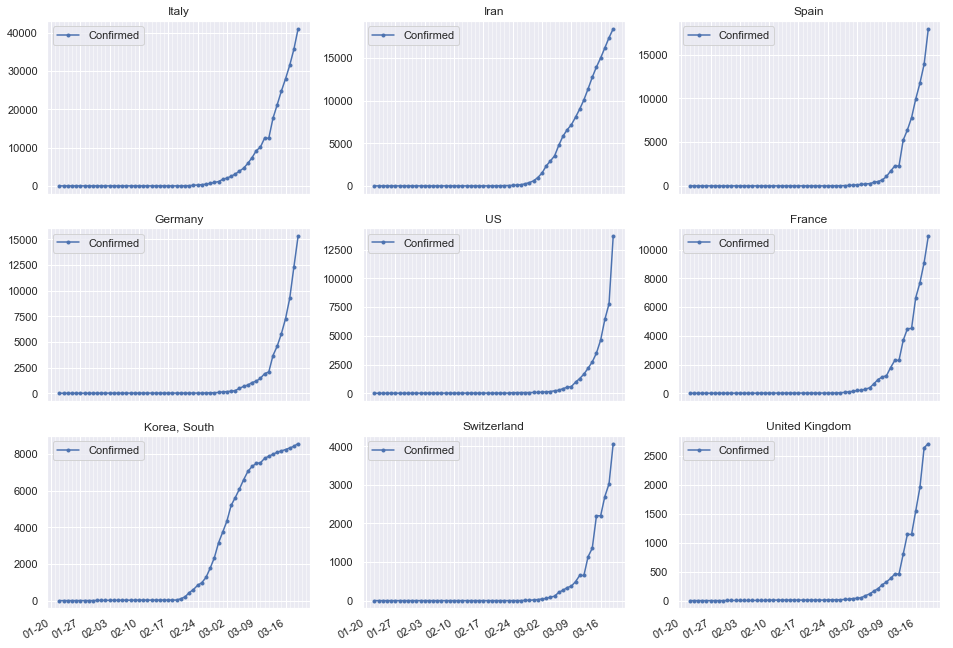

In [5]:
# Print top N as panel plot
fig_num = 1
top_countries = np.argsort(confirmed_country_totals[:, -1])[::-1]
fig = plt.figure(fig_num)
fig.clf()
axs = fig.subplots(3,3).reshape(-1)
fig.set_size_inches(16,12)
for c_idx in range(9):
    country_id = top_countries[c_idx + 1]
    axs[c_idx].plot(date_vec, confirmed_country_totals[country_id, :], marker='.', label='Confirmed')
#    axs[c_idx].plot(date_vec, deaths_country_totals[country_id, :], label='Deaths')
    axs[c_idx].set_title(countries_list[country_id])
    axs[c_idx].legend()
    axs[c_idx].xaxis.set_major_locator(loc_week)
    axs[c_idx].xaxis.set_minor_locator(loc_day)
    axs[c_idx].xaxis.set_major_formatter(date_formatter)
    axs[c_idx].grid(b=True, which='minor', color='w', linewidth=0.5)
    fig.autofmt_xdate()

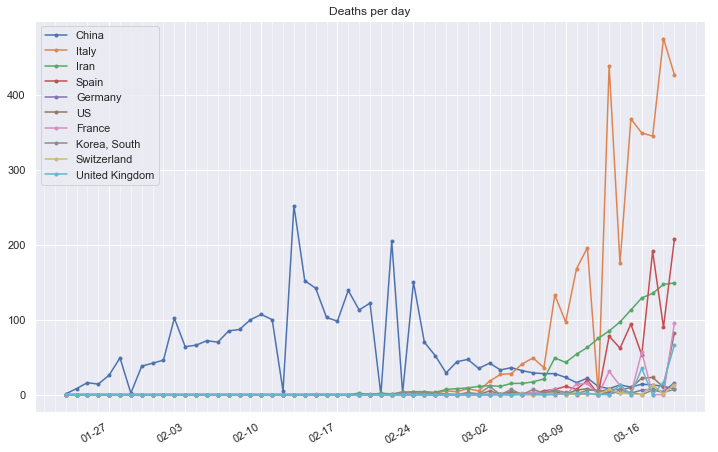

In [6]:
# Print top N deaths per day on one plot
top_countries = np.argsort(confirmed_country_totals[:, -1])[::-1]
fig_num += 1
fig = plt.figure(fig_num)
fig.clf()
fig.set_size_inches(12,8)
for c_idx in range(10):
    country_id = top_countries[c_idx]
    plt.plot(date_vec[1:], np.diff(deaths_country_totals[country_id, :]),
            label=countries_list[country_id], marker='.')
    
fig.axes[0].set_title('Deaths per day')
fig.axes[0].legend()
fig.axes[0].xaxis.set_major_locator(loc_week)
fig.axes[0].xaxis.set_minor_locator(loc_day)
fig.axes[0].xaxis.set_major_formatter(date_formatter)
fig.axes[0].grid(b=True, which='minor', color='w', linewidth=0.5)
fig.autofmt_xdate()

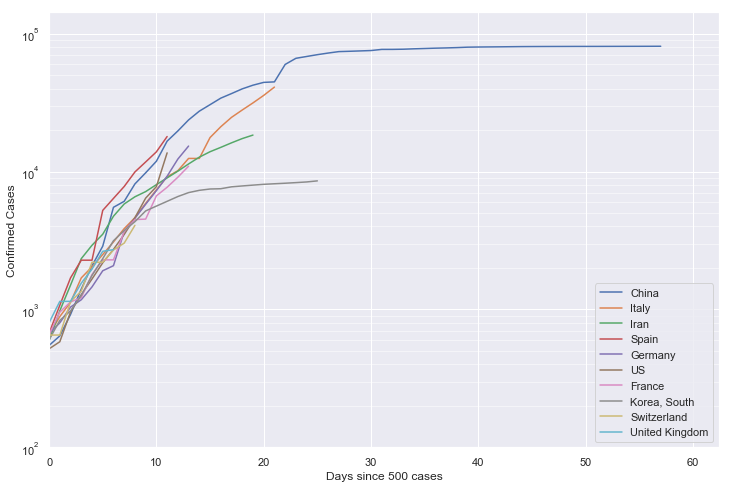

In [7]:
# Standardize on days since N infections
confirmed_threshold = 500
days_vec = np.arange(len(date_vec))
offset_vec = np.argmax(confirmed_country_totals > confirmed_threshold, axis=1)
fig_num += 1
fig = plt.figure(fig_num)
fig.clf()
fig.set_size_inches(12,8)
for c_idx in range(10):
    country_id = top_countries[c_idx]
    plt.semilogy(days_vec - offset_vec[country_id],
             confirmed_country_totals[country_id, :],
             label=countries_list[country_id])

plt.legend()
plt.xlim(0)
plt.ylim(100)
plt.xlabel('Days since %d cases' % (confirmed_threshold,))
plt.ylabel('Confirmed Cases')
fig.axes[0].grid(b=True, which='minor', color='w', linewidth=0.5)

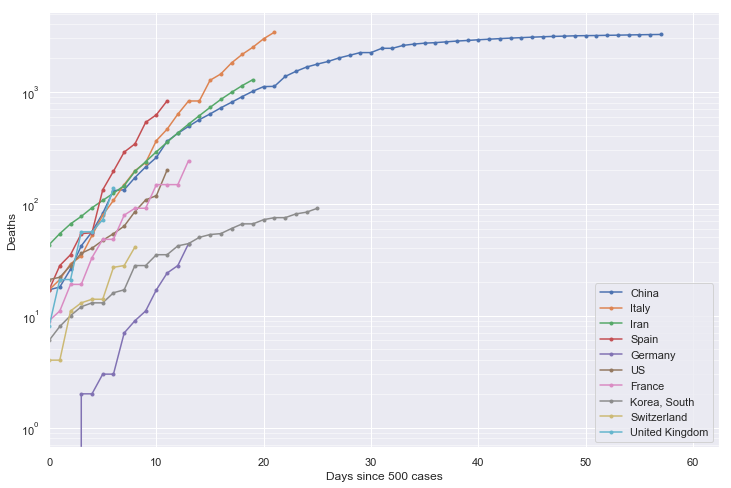

In [14]:
# Standardize on days since N infections
days_vec = np.arange(len(date_vec))
offset_vec = np.argmax(confirmed_country_totals > confirmed_threshold, axis=1)
fig_num += 1
fig = plt.figure(fig_num)
fig.clf()
fig.set_size_inches(12,8)
for c_idx in range(10):
    country_id = top_countries[c_idx]
    plt.semilogy(days_vec - offset_vec[country_id],
             deaths_country_totals[country_id, :],
             marker='.',
             label=countries_list[country_id])

plt.legend()
plt.xlim(0)
plt.xlabel('Days since %d cases' % (confirmed_threshold,))
plt.ylabel('Deaths')
fig.axes[0].grid(b=True, which='minor', color='w', linewidth=0.5)

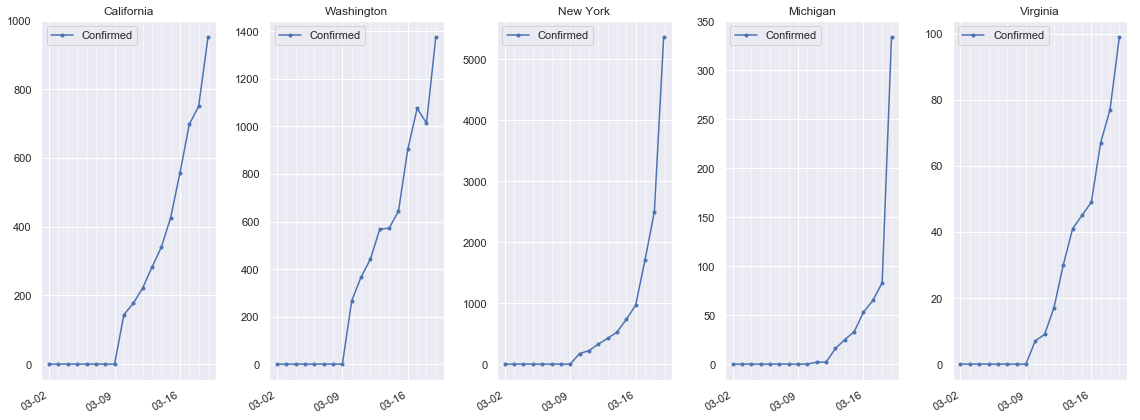

In [13]:
# Print selected states, confirmed and deaths
state_list = ['California', 'Washington', 'New York', 'Michigan', 'Virginia']
date_range = date_vec > mdates.date2num(pd.to_datetime('3/1/2020'))
# Print top N as panel plot
fig_num += 1
fig = plt.figure(fig_num)
fig.clf()
axs = fig.subplots(1,5).reshape(-1)
fig.set_size_inches(16,6)
for c_idx in range(len(state_list)):
    state_row = confirmed_df[confirmed_df['Province/State'] == state_list[c_idx]]
    axs[c_idx].plot(date_vec[date_range], state_row[np.array(col_names)[date_range]].T, marker='.', label='Confirmed')
#    axs[c_idx].plot(date_vec, deaths_country_totals[country_id, :], label='Deaths')
    axs[c_idx].set_title(state_list[c_idx])
    axs[c_idx].legend()
    axs[c_idx].xaxis.set_major_locator(loc_week)
    axs[c_idx].xaxis.set_minor_locator(loc_day)
    axs[c_idx].xaxis.set_major_formatter(date_formatter)
    axs[c_idx].grid(b=True, which='minor', color='w', linewidth=0.5)
fig.autofmt_xdate()
fig.tight_layout()